In [5]:
import numpy as np
from tqdm import tqdm
import shutil
from PIL import Image
import cv2
import os
import SimpleITK as sitk
import pickle
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

In [ ]:
!mkdir dataset
!mkdir dataset/test
!mkdir dataset/train
!mkdir dataset/val
!mkdir dataset/test/images
!mkdir dataset/test/masks
!mkdir dataset/train/images
!mkdir dataset/train/masks
!mkdir dataset/val/images
!mkdir dataset/val/masks

In [6]:
with open('/kaggle/input/spacings/pixel_spacings.pkl', 'rb') as f:
    pixel_spacings = pickle.load(f)

In [7]:
images=os.listdir('/kaggle/input/lidc-idri-preprocessed/CT images and masks/train/images')
print(len(images))

14343


In [7]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Используемое устройство: {device}")

Используемое устройство: cpu


In [8]:
def interpolate(img, mask, original_spacing, img_name) :
    new_spacing = [0.4609375, 0.4609375] 
    original_size = [512, 512]
    new_size = [
        int(round(original_size[i] * (original_spacing[i] / new_spacing[i])))
        for i in range(2) 
    ]
    #print(original_spacing, new_spacing)
    #print(new_size)

    resampler = sitk.ResampleImageFilter()
    resampler.SetSize(new_size)
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetOutputDirection([1, 0, 0, 1])
    resampler.SetOutputOrigin([0, 0])
    resampler.SetInterpolator(sitk.sitkBSpline)
    img=sitk.GetImageFromArray(img)

    img.SetSpacing((original_spacing[0], original_spacing[1]))       
    img.SetOrigin((0.0, 0.0))          
    img.SetDirection([1.0, 0.0, 0.0, 1.0])
    image_resampled = resampler.Execute(img)





    mask=sitk.GetImageFromArray(mask)
    mask.SetSpacing((original_spacing[0], original_spacing[1]))       
    mask.SetOrigin((0.0, 0.0))          
    mask.SetDirection([1.0, 0.0, 0.0, 1.0])
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    mask_resampled = resampler.Execute(mask)

    '''
    if Image.fromarray(image_resampled).shape[0]>1100 :
        raise ValueError("Изображение {img_name} после интерполяции больше 1100 пикселей")
    '''
    delta = 1100 - new_size[0]
    pad = (delta // 2, delta - delta // 2)

    #print(image_resampled.GetSize())

    image_resampled=sitk.GetArrayFromImage(image_resampled)
    mask_resampled=sitk.GetArrayFromImage(mask_resampled)

    #print(image_resampled.shape)
    #print(mask_resampled.shape)
    #print(pad)
    image_padded = np.pad(image_resampled, ((pad), (pad)), mode='constant', constant_values=0)
    mask_padded = np.pad(mask_resampled, ((pad), (pad)), mode='constant', constant_values=0)
    return image_padded, mask_padded


In [9]:


images=os.listdir('/kaggle/input/lidc-idri-preprocessed/CT images and masks/train/images')
for i  in tqdm(range(len(images))) :
    img_path = '/kaggle/input/lidc-idri-preprocessed/CT images and masks/train/images/'+images[i]
    img = Image.open(img_path)
    img = np.array(img, dtype=np.uint8)
    mask_path = '/kaggle/input/lidc-idri-preprocessed/CT images and masks/train/masks/'+images[i]
    mask = Image.open(mask_path)
    mask = np.array(mask, dtype=np.uint8)
    patient_id=images[i][:-8]
    new_img, new_mask=interpolate(img, mask, [pixel_spacings[patient_id], pixel_spacings[patient_id]], images[i])
    new_path='/kaggle/working/dataset/train/images/'+images[i]
    image = Image.fromarray(new_img)
    image.save(new_path)

    new_path='/kaggle/working/dataset/train/masks/'+images[i]
    image = Image.fromarray(new_mask)
    image.save(new_path)
    

100%|██████████| 14343/14343 [50:50<00:00,  4.70it/s] 


In [14]:
images=os.listdir('/kaggle/input/lidc-idri-preprocessed/CT images and masks/val/images')
for i  in tqdm(range(len(images))) :
    img_path = '/kaggle/input/lidc-idri-preprocessed/CT images and masks/val/images/'+images[i]
    img = Image.open(img_path)
    img = np.array(img, dtype=np.uint8)
    mask_path = '/kaggle/input/lidc-idri-preprocessed/CT images and masks/val/masks/'+images[i]
    mask = Image.open(mask_path)
    mask = np.array(mask, dtype=np.uint8)
    patient_id=images[i][:-8]
    new_img, new_mask=interpolate(img, mask, [pixel_spacings[patient_id], pixel_spacings[patient_id]], images[i])
    
    new_path='/kaggle/working/dataset/val/images/'+images[i]
    image = Image.fromarray(new_img)
    image.save(new_path)

    new_path='/kaggle/working/dataset/val/masks/'+images[i]
    image = Image.fromarray(new_mask)
    image.save(new_path)
    

100%|██████████| 3391/3391 [12:26<00:00,  4.54it/s]


In [15]:
images=os.listdir('/kaggle/input/lidc-idri-preprocessed/CT images and masks/test/images')
for i  in tqdm(range(len(images))) :
    img_path = '/kaggle/input/lidc-idri-preprocessed/CT images and masks/test/images/'+images[i]
    img = Image.open(img_path)
    img = np.array(img, dtype=np.uint8)
    mask_path = '/kaggle/input/lidc-idri-preprocessed/CT images and masks/test/masks/'+images[i]
    mask = Image.open(mask_path)
    mask = np.array(mask, dtype=np.uint8)
    patient_id=images[i][:-8]
    new_img, new_mask=interpolate(img, mask, [pixel_spacings[patient_id], pixel_spacings[patient_id]], images[i])
    
    new_path='/kaggle/working/dataset/test/images/'+images[i]
    image = Image.fromarray(new_img)
    image.save(new_path)

    new_path='/kaggle/working/dataset/test/masks/'+images[i]
    image = Image.fromarray(new_mask)
    image.save(new_path)

100%|██████████| 3330/3330 [12:03<00:00,  4.60it/s]


  0%|          | 0/14343 [00:00<?, ?it/s]

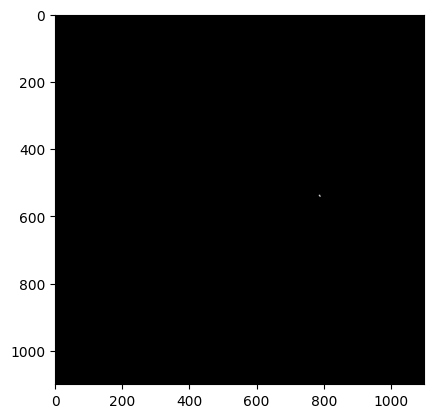

/kaggle/working/dataset/train/images/LIDC-IDRI-0442_085.png


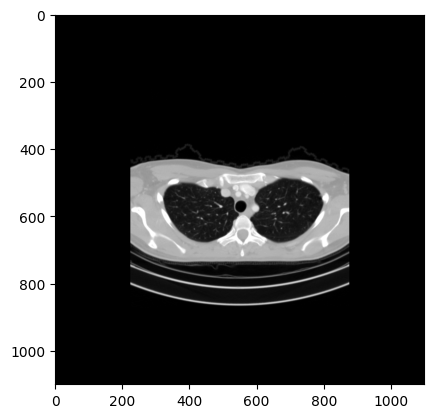

  0%|          | 3/14343 [00:00<40:22,  5.92it/s]


In [12]:
import matplotlib.pyplot as plt
import random
images=os.listdir('/kaggle/working/dataset/train/masks')
random.shuffle(images)
for i  in tqdm(range(len(images))) :
    img_path = '/kaggle/working/dataset/train/masks/'+images[i]
    img = Image.open(img_path)
    img = np.array(img, dtype=np.uint8)
    if np.max(img)!=0 :
        print(np.max(img))
        mask_path = '/kaggle/working/dataset/train/masks/'+images[i]
        mask = Image.open(img_path)
        mask = np.array(mask, dtype=np.uint8)
        thresholded_mask = mask > 0  
        thresholded_mask = thresholded_mask.astype(np.uint8) * 255
        plt.imshow(thresholded_mask, cmap='gray')  
        plt.show()

        img_path = '/kaggle/working/dataset/train/images/'+images[i]
        img = Image.open(img_path)
        print(img_path)
        img = np.array(img, dtype=np.uint8)
        plt.imshow(img, cmap='gray')  
        plt.show()
        break

 22%|██▏       | 3218/14343 [00:15<00:53, 206.65it/s]

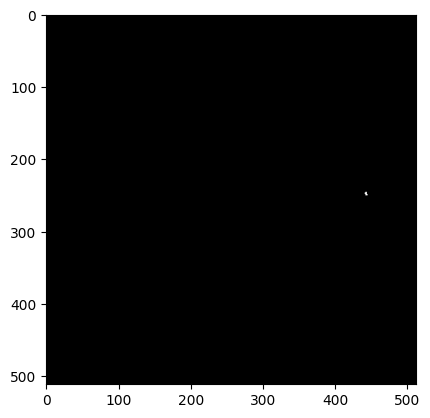

/kaggle/input/lidc-idri-preprocessed/CT images and masks/train/images/LIDC-IDRI-0442_085.png


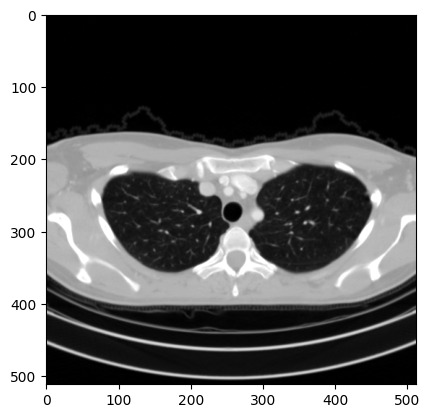

 22%|██▏       | 3219/14343 [00:16<00:55, 200.46it/s]


In [13]:

import matplotlib.pyplot as plt
images=os.listdir('/kaggle/input/lidc-idri-preprocessed/CT images and masks/train/masks')
for i  in tqdm(range(len(images))) :
    img_path = '/kaggle/input/lidc-idri-preprocessed/CT images and masks/train/masks/'+images[i]
    img = Image.open(img_path)
    img = np.array(img, dtype=np.uint8)
    if images[i]=='LIDC-IDRI-0442_085.png' :#'LIDC-IDRI-0188_060.png'  :

        mask_path = '/kaggle/input/lidc-idri-preprocessed/CT images and masks/train/masks/'+images[i]
        mask = Image.open(img_path)
        mask = np.array(mask, dtype=np.uint8)
        thresholded_mask = mask > 0  
        thresholded_mask = thresholded_mask.astype(np.uint8) * 255
        plt.imshow(thresholded_mask, cmap='gray')  
        plt.show()

        img_path = '/kaggle/input/lidc-idri-preprocessed/CT images and masks/train/images/'+images[i]
        img = Image.open(img_path)
        print(img_path)
        img = np.array(img, dtype=np.uint8)
        plt.imshow(img, cmap='gray')  
        plt.show()
        break

In [16]:
import zipfile


folder_path = '/kaggle/working/dataset'

zip_path = '/kaggle/working/archive.zip'

with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), folder_path))

print(f'Архив сохранен по пути: {zip_path}')


Архив сохранен по пути: /kaggle/working/archive.zip
